# Water Observations from Space (WOfS) <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2), 
[ga_ls8c_wofs_2_summary](https://explorer.digitalearth.africa/ga_ls8c_wofs_2_summary)

## Background

[Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) are a suite of surface water products. They are generated using the WOfS classification algorithm on Landsat 8 satellite data. There are several WOfS products available for the African continent, as listed below:

|Product Type| Description |
|----------|----------------|
| WOfS Annual Summary | The ratio (%) of wet to clear observations from each calendar year|
| WOfS All-Time Summary| The ratio (%) of wet to clear observations over all time|
| WOFLs (WOfS Feature Layers)|WOfS slices generated per scene |
| *WOfS Filtered Summary (Under development)* | *All-time summary checked against the confidence layer* ||

__WOfS Annual/All-Time Summary:__ The percentage of time a pixel was classified as wet. This requires:

- Total number of clear observations for each pixel: the number of observations that were clear (no cloud or shadow) for the selected time period. The classification algorithm then assigns these as either wet, or dry.
- Total number of wet observation for each pixel: the number of observations that were clear *and* wet for the selected time period.

The WOfS Summary is calculated as the ratio of clear wet observations to total clear observations, expressed as a percentage.

$$ \text{WOfS Summary} = \frac{\text{Number of Wet Observations}}{\text{Number of (Wet + Dry) Observations}} \times 100 $$

__WOFLs (WOfS Feature Layers):__ Individual water-classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. Hence there is one WOFL for each satellite dataset processed for the occurrence of water. For more information on WOFLs, see the [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebook.

__WOfS Filtered Summary:__ The percentage of time a pixel was classified as wet, filtered using the confidence layer. The Filtered Summary is the WOfS Summary where areas with less than 10% confidence have been removed. This product is still under development for Africa.

## Description

This notebook explains loading and using WOFLs to visualise WOfS over a chosen time period. 

This notebook demonstrates how to:
1. Show WOfS for a single timestep using WOFLs for a selected time and place.
2. Show WOfS averaged over a selected time period.
3. Save a WOFL to a Cloud Optimised Geotiff (COG).

***

## Getting Started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages 

In [1]:
%matplotlib inline

# Modules for the datacube 
import datacube
from datacube.storage import masking
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube.utils.cog import write_cog 
import numpy as np
import pandas as pd 
import seaborn as sn
import xarray as xr 
import sys

# Modules for plotting 
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from deafrica_plotting import display_map
from deafrica_datahandling import wofs_fuser, mostcommon_crs

# Ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Intro_WOfS")

### List of WOfS products available in Digital Earth Africa

In [3]:
pd.set_option('display.max_colwidth', None)

products = dc.list_products()
display_columns = ['name', 'description']
dc_products = products[display_columns]
dc_products[dc_products['name'].str.contains("wofs")]

,name,description
id,,
15,ga_ls8c_wofs_2,Historic Flood Mapping Water Observations from Space
13,ga_ls8c_wofs_2_annual_summary,Water Observations from Space Annual Statistics
16,ga_ls8c_wofs_2_summary,Water Observations from Space Full History Statistics
5,ls_usgs_wofs_scene,Historic Flood Mapping Water Observations from Space
11,ls_usgs_wofs_summary,Water Observations from Space Annual Statistics


### Analysis parameters 

The following items are included in the "query" that defines what the datacube need to return. 

- `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
- `time`: date range to fetch the scenes. The approximate time between two scenes is 16 days. If there is a location near a swathe boundary, it may be captured in two passes and so there could be two images within the 16 day period.
- `output_crs`: the coordinate reference system of the query. 

The default location is Lake Sulunga in Tanzania.

In [4]:
lat, lon =  -6.083 ,35.184
buffer = 0.25

x = (lon-buffer, lon+buffer)
y =  (lat+buffer, lat-buffer)

# Create a reusable query
query = {
    'x': x,
    'y': y,
    'time': ('2015-01-01', '2019-03-20'),
    'resolution': (-30, 30)
}

output_crs = mostcommon_crs(dc=dc, product='ga_ls8c_wofs_2', query=query)

../Scripts/deafrica_datahandling.py:600: UserWarning: Multiple UTM zones ['epsg:32636', 'epsg:32637'] were returned for this query. Defaulting to the most common zone: epsg:32636
  UserWarning)


### View the selected location

In [5]:
# View the location 
display_map(x=x, y=y)

### WOfS Feature Layers (WOFLs) 

WOFLs use [bit flags](http://datacube-core.readthedocs.io/en/latest/dev/api/masking.html) to flag pixels as "wet" or otherwise. For more details on bitmasking with WOfS, see the [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebook. Here, it is not necessary to directly call on the bit flags as we can use the selection `wet=True` to create the water mask, while `dry=True` gives the opposite. In this case, `isel` is used to select a single timestep, and shows the wet/dry pixels for that increment only.

In [6]:
# Load WOfS feature layers 
wofls= dc.load(product = 'ga_ls8c_wofs_2',group_by="solar_day",fuse_func=wofs_fuser, output_crs = output_crs,**query)
print(wofls)

<xarray.Dataset>
Dimensions:      (time: 190, x: 1853, y: 1852)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-05T07:44:25.672915 ... 2019-03-12T07:50:10.449636
  * y            (y) float64 -6.451e+05 -6.451e+05 ... -7.006e+05 -7.006e+05
  * x            (x) float64 7.14e+05 7.14e+05 7.14e+05 ... 7.695e+05 7.695e+05
    spatial_ref  int32 32636
Data variables:
    water        (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref


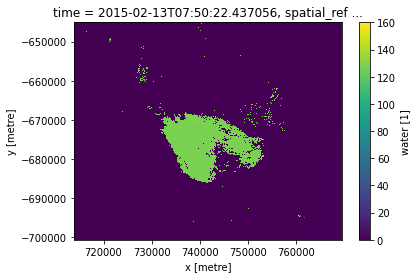

In [7]:
# Show areas that are water in the 5th timestep
wofls.water.isel(time=5).plot()

### WOFL masks for a single timestep

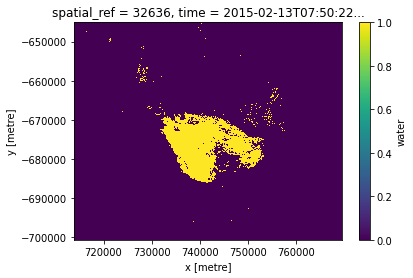

In [8]:
wetwofl = masking.make_mask(wofls, wet=True)
wetwofl.water.isel(time=5).plot()

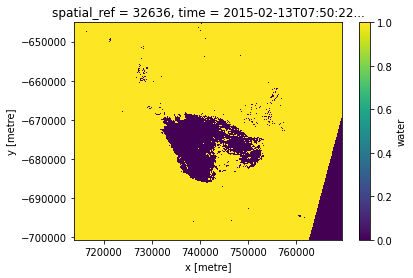

In [9]:
drywofl = masking.make_mask(wofls, dry=True)
drywofl.water.isel(time=5).plot()

### Percentage of time the lake was wet

To look at a summary of WOfS over multiple timesteps, it is advantageous to use the `ga_ls8c_wofs_2_summary` product. Feeding in the same query gives a frequency map for the time eriod defined previously.

In [10]:
freq = dc.load(product = 'ga_ls8c_wofs_2_summary', output_crs = output_crs,**query)

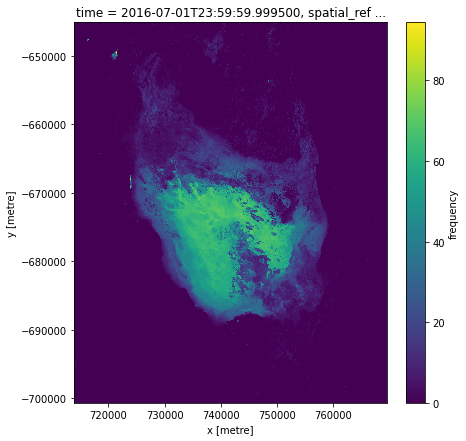

In [11]:
(freq.frequency*100).plot(figsize = (7,7))

### Save WOFL to Cloud Optimised Geotiff (COG)

This method uses the `datacube.utils.cog` function [write_cog](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.utils.cog.write_cog.html),to export a simple single-band, single time-slice `COG`. `COG` stands for [Cloud-Optimised-Geotiff](https://www.cogeo.org/).

A few important caveats should be noted when using this function:
* It requires an `xarray.DataArray`; supplying an `xarray.Dataset` will return an error. To convert a `xarray.Dataset` to an array run the following: 

        da = ds.to_array()

* This function generates a temporary in-memory `tiff` file without compression.  This means the function will use about 1.5 to 2 times the memory required using the depreciated `datacube.helper.write_geotiff`.

* If you pass a `dask array` into the function, `write_cog` will not output a `GeoTIFF`, but will instead return a` Dask Delayed` object. To trigger the output of the `GeoTIFF`, run `.compute()` on the dask delayed object: 

        write_cog(ds.red.isel(time=0), "red.tif").compute()

In [12]:
# Write the WOFLs query to COG format 
write_cog(wofls.water.isel(time=5),fname="wofls_saved",overwrite=True)

PosixPath('wofls_saved')

For more examples on how WOfS can be used for water resource management, also see the [Water extent](../Real_world_examples/Water_extent.ipynb) notebook in the DE Africa sandbox.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** July 2020

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.2.dev7+gdcab0e02


## References

Github Repository https://github.com/GeoscienceAustralia/wofs

Mueller, et al. 2015. *Water observations from space: Mapping surface water from 25 years of Landsat imagery across Australia*, Remote Sensing of Environment. https://doi.org/10.1016/j.rse.2015.11.003

GA, 2017. *Water Observations from Space 2.1.5 Product Description.* https://cmi.ga.gov.au/wo_25_2.1.5

GA, 2017. *Water Observations from Space Statistics 25m 2.1.5*, https://cmi.ga.gov.au/wo-stats_25_2.1.5

GA, 2017. *Water Observations from Space Filtered Statistics 25m 2.1.5 Product Description*
https://data.dea.ga.gov.au/WOfS/filtered_summary/v2.1.0/Product%20Description.pdf